In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_path = ("/Users/gemma/Documents/data science/DS bootcamp/"
             "sentiment labelled sentences/imdb_labelled.txt"
            )
sent = pd.read_csv(data_path, delimiter= '\t', header=None)
sent.columns = ['sentence', 'sentiment']

In [4]:
sent.head(3)

,sentence,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0


## Feature selection process

In order to select the features for the model, I decided to look at all of the words in each of the sentences to see which words were most commonly featured in positive reviews, and which words were most commonly featured in negative reviews. 

Then, I selected a handful of words from each group as the features. I tried to select words that, even if they overlapped and were in both groups (positive and negative reviews), they were more commonly in one group or the other.

Also, in order to catch more sentences, I tried to limit the amount of content words unless they were very highly popular, and instead tried to choose function words that carried some sort of connotation that correleated with the reviews it was in - i.e., I ignored 'a', because the article doesn't have any connotation, but selected 'didn't', because this was so common in negative reviews, and has a negative meaning.

In [5]:
def wordc(string):
    
    words = []
    counts = []
    
    checkpt = -1
#in a loop...
    # find first word
    for idx,letter in enumerate(string):
        
        # if you find a space and its not the first char 
        if (letter.isspace() and idx > 0):
            if string[checkpt+1:idx] not in words:
                # add to the word list
                words.append(string[checkpt+1:idx])
                # add a count
                counts.append(1)   
            # if its already in the word list
            else:
                # find where the word is in the word list
                target = words.index(string[checkpt+1:idx])

                # then increment the count in the same location
                counts[target] = counts[target]+1
            # then update the checkpoint to the space
            checkpt = idx
            
        # or if you're at the end of the string
        elif (idx == len(string)-1):

            if string[checkpt+1:] not in words:
                # add to the word list
                words.append(string[checkpt+1:])
                # add a count
                counts.append(1)   
            # if its already in the word list
            else:
                # find where the word is in the word list
                target = words.index(string[checkpt+1:])

                # then increment the count in the same location
                counts[target] = counts[target]+1
                        
    return(words,counts)

In [6]:
wordc("lamp ok lamp so")

(['lamp', 'ok', 'so'], [2, 1, 1])

In [8]:
import string

#same function as before but split into two so its less redudant, and 2 changes: 
# uses lists defined outside the function
# and adjusts the case and punctuation of the string, so its more accurate

def findoradd(word,wordlist,countlist):
    if word not in wordlist:
        # add to the word list
        wordlist.append(word)
        # add a count
        countlist.append(1)   
    # if its already in the word list
    else:
        # find where the word is in the word list
        target = wordlist.index(word)

        # then increment the count in the same location
        countlist[target] = countlist[target]+1
    return

# to use this the word list and countlist need to be defined before calling the func
def wordc2(sentence, words, counts):
    # make it all lowercase
    sentence = sentence.casefold()
    
    # get rid of punctuation
    translator=str.maketrans('','',string.punctuation)
    sentence=sentence.translate(translator)
    
    checkpt = -1
    
#in a loop...
    # find first word
    for idx,letter in enumerate(sentence):
        
        # if you find a space and its not the first char 
        if (letter.isspace() and idx > 0):
            
            #use the function above
            findoradd(sentence[checkpt+1:idx], words, counts)
            
            #update checkpt
            checkpt = idx
            
        # or if you're at the end of the string
        elif (idx == len(sentence)-1):
            
            findoradd(sentence[checkpt+1:], words, counts)
                        
    return(words,counts)

In [9]:
# testing out my new function to make sure it works correctly

fakew = []
fakec = []
wordc2("Lamp ok lamp so", fakew, fakec)

(['lamp', 'ok', 'so'], [2, 1, 1])

In [10]:
# separating the sentences by sentiment
pos = sent[sent['sentiment'] == 1]['sentence']
neg = sent[sent['sentiment'] == 0]['sentence']

In [11]:
# getting the list of common words for sentences associated with each sentiment
allpos = pos.tolist()

poswords = []
poscount = []
for words in allpos:
    wordc2(words,poswords,poscount)

allneg = neg.tolist()

negwords = []
negcount = []
for item in allneg:
    wordc2(item,negwords,negcount)

In [12]:
# make a dataframe of the positive words

posdf = pd.DataFrame(index=range(len(poswords)))

# Add our columns to the data frame one at a time.
posdf['words'] = poswords
posdf['pos_count'] = poscount
posdf.head(3)

,words,pos_count
0,the,407
1,best,16
2,scene,6


In [13]:
# make a dataframe of the negative words

negdf = pd.DataFrame(index=range(len(negwords)))

# Add our columns to the data frame one at a time.
negdf['words'] = negwords
negdf['neg_count'] = negcount
negdf.head(3)

,words,neg_count
0,a,200
1,very,37
2,slowmoving,1


In [14]:
# attempting to merge the dataframes together to better compare them
attempt1 = pd.concat([posdf,negdf], ignore_index=True)

attempt1.head(3)

,neg_count,pos_count,words
0,NaN,407.0,the
1,NaN,16.0,best
2,NaN,6.0,scene


In [22]:
# since that didn't have the desired outcome, trying a different way to merge them
attempt2 = pd.merge(posdf, negdf, how='outer', on='words')

attempt2.fillna(value=0,inplace=True)

attempt2.head(5)

,words,pos_count,neg_count
0,the,407.0,435.0
1,best,16.0,9.0
2,scene,6.0,8.0
3,in,108.0,94.0
4,movie,84.0,93.0


In [24]:
# taking a look at the data sorted by how by times word appeared in positive reviews
attempt2.sort_values('pos_count', ascending=False).head(3)

,words,pos_count,neg_count
20,,542.0,757.0
0,the,407.0,435.0
23,and,251.0,178.0


In [39]:
# adding a boolean value for whether or not the word had a greater count in one sentiment
# or another, to make sure to select good words for the features

attempt2['greater'] = np.where(attempt2['pos_count']>attempt2['neg_count'], 1, 0)

In [40]:
attempt2.head(3)

,words,pos_count,neg_count,greater
0,the,407.0,435.0,0
1,best,16.0,9.0,1
2,scene,6.0,8.0,0


In [97]:
# taking a look at all of the words that appeared mostly in positive reviews, 
# in order of most occuring to least

bestpos = attempt2.loc[(attempt2['greater'] == 1)]

bestpos.sort_values('pos_count', ascending=False).head(55)

,words,pos_count,neg_count,greater
23,and,251.0,178.0,1
12,a,230.0,200.0,1
71,i,140.0,126.0,1
3,in,108.0,94.0,1
79,film,84.0,71.0,1
184,with,48.0,41.0,1
48,its,47.0,41.0,1
160,are,38.0,37.0,1
26,good,35.0,21.0,1
47,at,28.0,26.0,1


In [98]:
# from this list, positive words are..

yes = ['best', 'good', 'loved', 'adorable', 'cool', 'hilarious', 'really', 'wonderful', 'great']


In [99]:
# same thing as before but with negative words

worstneg = attempt2.loc[(attempt2['greater'] == 0)]

worstneg.sort_values('neg_count', ascending=False).head(55)


,words,pos_count,neg_count,greater
20,,542.0,757.0,0
0,the,407.0,435.0,0
33,of,184.0,191.0,0
8,is,152.0,188.0,0
58,this,134.0,156.0,0
10,to,112.0,139.0,0
25,it,118.0,134.0,0
5,was,74.0,111.0,0
315,1,24.0,95.0,0
4,movie,84.0,93.0,0


In [100]:
# from this list, some negative words

no = ['only', 'bad', 'even', 'didn\'t', 'not', 'slow', 'little', 'so']

In [101]:
# adding the keywords as features to the original table 

keywords = no + yes

for key in keywords:
    sent[str(key)] = sent.sentence.str.contains(
        str(key), 
        case=False
    )

In [79]:
sent.head(4)

,sentence,sentiment,only,bad,even,didnt,not,best,good,loved,adorable,cool,hilarious,slow,little,really,wonderful,didn't
0,"A very, very, very slow-moving, aimless movie ...",0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,Not sure who was more lost - the flat characte...,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,Attempting artiness with black & white and cle...,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Very little music or anything to speak of.,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


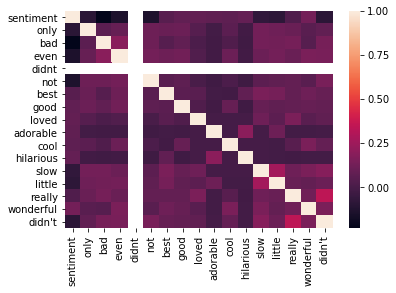

In [77]:
# heatmap to better visualize correlations between data

sns.heatmap(sent.corr())

This correlation heatmap shows the independence of the selected keywords from each other.

In [80]:
# training the model
data = sent[keywords]
target = sent['sentiment']

In [81]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 748 points : 261


In [82]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(data, target).predict(data)
print("Number of mislabeled points out of a total %d points : %d"
      % (data.shape[0],(target != y_pred).sum()))

Number of mislabeled points out of a total 748 points : 347


## Testing the model with different data to see how it works

### Amazon reviews

In [83]:
data_path = ("/Users/gemma/Documents/data science/DS bootcamp/"
             "sentiment labelled sentences/amazon_cells_labelled.txt"
            )
amsent = pd.read_csv(data_path, delimiter= '\t', header=None)
amsent.columns = ['sentence', 'sentiment']

In [102]:
for key in keywords:
    amsent[str(key)] = amsent.sentence.str.contains(
        str(key), 
        case=False
    )

In [103]:
amsent.head(3)

,sentence,sentiment,only,bad,even,didn't,not,slow,little,best,good,loved,adorable,cool,hilarious,really,wonderful,so,great
0,So there is no way for me to plug it in here i...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,"Good case, Excellent value.",1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


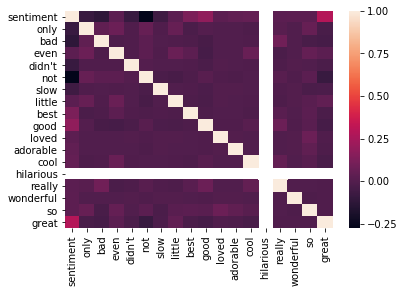

In [104]:
sns.heatmap(amsent.corr())

In [105]:
data2 = amsent[keywords]
target2 = amsent['sentiment']

In [107]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data2, target2)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data2)

# Display results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data2.shape[0],
    (target2 != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 344


### Yelp reviews

In [108]:
data_path = ("/Users/gemma/Documents/data science/DS bootcamp/"
             "sentiment labelled sentences/yelp_labelled.txt"
            )
ysent = pd.read_csv(data_path, delimiter= '\t', header=None)
ysent.columns = ['sentence', 'sentiment']

In [109]:
for key in keywords:
    ysent[str(key)] = ysent.sentence.str.contains(
        str(key), 
        case=False
    )

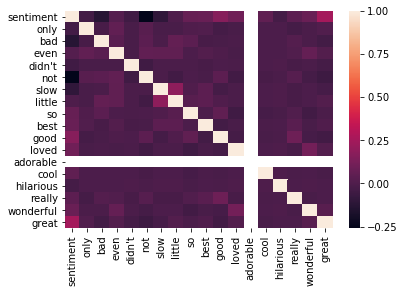

In [110]:
sns.heatmap(ysent.corr())

In [111]:
data3 = amsent[keywords]
target3 = amsent['sentiment']

In [112]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data3, target3)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data3)

# Display results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data3.shape[0],
    (target3 != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 344
